In [1]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
import scipy.ndimage as nd
from array import array
from functions_MuonsNSAMP1 import *
import time

from ROOT import TProfile, TGraphErrors, TH2F

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Colormap = 'jet'

# print(time.time())
# print(time.gmtime(0))

Welcome to JupyROOT 6.28/04


In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth": 3,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Colormap = 'jet'

## imagen y máscara (script Jaime) 

In [ ]:
path = "../clean_images_Jaime/images_elec_curv/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits"
path_mask = "../clean_images_Jaime/images_elec_curv/mask/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100_mask.fits"


extension = 1
# for index in np.arange(0, len(list_path)):
hdu_list = fits.open(path)
hdumask_list = fits.open(path_mask)


active_area = hdu_list[extension-1].data[10:640, 10:550]
Overscan = hdu_list[extension - 1].data[10:640, 550:690]

active_area_mask = hdu_list[extension-1].data[10:640, 10:550]
Overscan_mask = hdu_list[extension - 1].data[10:640, 550:690]


Vmax = 100000

fig, axs = plt.subplots(2,2, figsize = [15,15])
axs[0][0].imshow(active_area, vmin = 100, vmax = Vmax)
axs[0][1].imshow(Overscan, vmin = 0, vmax = Vmax)

axs[1][0].imshow(active_area_mask, vmin = 100, vmax = Vmax)
axs[1][1].imshow(Overscan_mask, vmin = 0, vmax = Vmax)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'images/Pruebas_Mau/Fe55_NSMAP200/proc_skp_m-009_microchip_T_150__Vv82_NSAMP_200_NROW_250_NCOL_700_EXPOSURE_20_NBINROW_1_NBINCOL_1_img_62.fits'

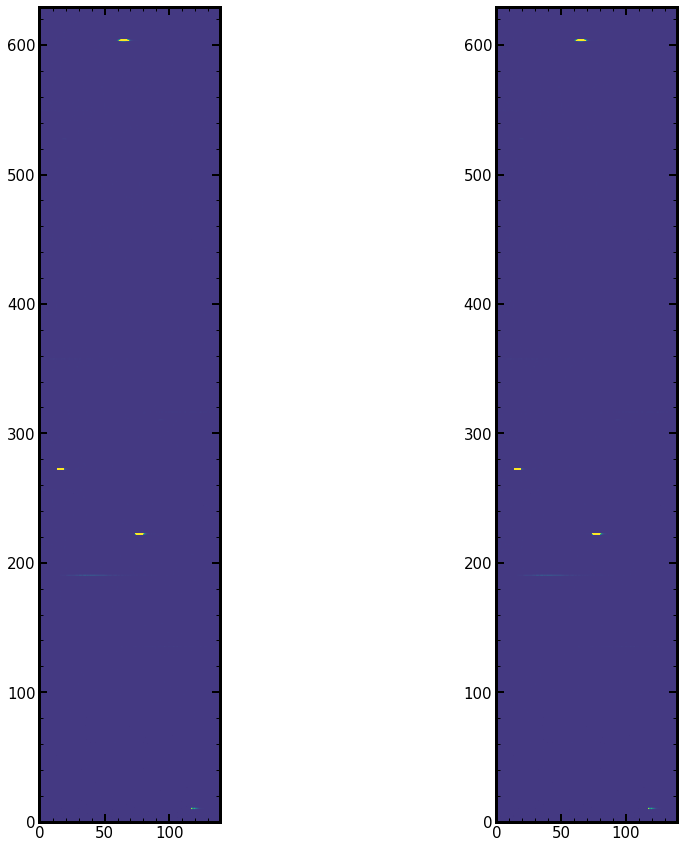

In [72]:
Vmax = 90000
fig, axs = plt.subplots(1,2, figsize = [15,15])
axs[0].imshow(Overscan, vmin = 0, vmax = Vmax)
axs[1].imshow(Overscan_mask, vmin = 0, vmax = Vmax)

plt.show()

## Multiples imágenes (ADUs)

In [127]:
extension = 1
Bins = 600
Bins_fit = 600
Range_fit = [-30, 350]

list_path = [
            '../images/Pruebas_Mau/Fe55_NSMAP200/proc_skp_m-009_microchip_T_150__Vv82_NSAMP_200_NROW_250_NCOL_700_EXPOSURE_20_NBINROW_1_NBINCOL_1_img_65.fits',]
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_91.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_92.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_93.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_94.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_95.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_96.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_97.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_98.fits',
            # #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_99.fits', ## Imagen dañada
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_103.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_105.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_106.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_107.fits',]
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_108.fits',
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_109.fits']
list_data_image = []
Gain_ref = 197.99

c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)

for index in np.arange(0, len(list_path)):
    hdu_list = fits.open(list_path[index])
    # hdu_list = fits.open(path)
    active_area = hdu_list[extension-1].data[10:, 10:539]
    Overscan = hdu_list[extension - 1].data[10:, 539:]

    # fig, axs = plt.subplots(1,2,figsize = [10,10])
    # axs[0].imshow(active_area, vmax = 100000, vmin = 1)
    # axs[1].imshow(Overscan, vmax = 100000, vmin = 1)
    # plt.show()

    # print('Dimensiones Oscan: ', Overscan.shape)
    oscan_x = Overscan.shape[1]
    oscan_y = Overscan.shape[0]


    ### Dimensiones de Active Area
    # print('Dimensiones ActA: ', active_area.shape)
    acta_x = active_area.shape[1]
    acta_y = active_area.shape[0]

    ### Se sustrae la mediana de cada renglón y se crea un arreglo
    mean_rows_value = []

    for element in np.arange(0, oscan_y):
        row = Overscan[element: element +1, 0: oscan_x]
        num_row = element + 1
        mean_value = np.median(row)
        # print(mean_value)
        mean_rows_value.append([mean_value])
        # print((num_row, mean_value))

    


### In ADUs

In [128]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = (active_area - mean_rows_value)

# fig, axs = plt.subplots(1,2,figsize = [10,10])
# axs[0].imshow(true_active_area, vmax = 100000, vmin = 1)
# axs[1].imshow(Overscan, vmax = 100000, vmin = 1)
# plt.show()

# fig, axs = plt.subplots(figsize = [6,6])
# axs.hist(true_active_area.flatten(), bins=200, range = [-1, 5], histtype='step')
# axs.set_yscale('log')

Range = [-150, 350]
Bins_fit=150
histActA=TH1F("histogram", "Distribution of Active Area",Bins_fit, Range[0], Range[1])
for pixel_value in true_active_area.flatten():
    # if not np.ma.is_masked(pixel_value):
    histActA.Fill(pixel_value)
    #print(pixel_value)

Range_fit = [-100, 50]
# fgaus1 = TF1("fgauss1","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) 
fgaus1 = TF1("fgaus1","[0]*exp(-0.5*((x-[1])/[2])^2)",Range_fit[0],Range_fit[1]) 
fgaus1.SetParameters(500, -20, 50) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histActA.Fit(fgaus1, "RQ")

Range_fit = [130, 270]# print("Prob:", fgaus2.GetProb(), '\n')
# fgaus1 = TF1("fgauss1","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) 
fgaus2 = TF1("fgaus2","[0]*exp(-0.5*((x-[1])/[2])^2)",Range_fit[0],Range_fit[1]) 
fgaus2.SetParameters(500, 3, 50) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histActA.Fit(fgaus2, "RQ")

histActA.Draw()
fgaus1.Draw('same')
fgaus2.Draw('same')
c1.Draw()

print('Parameters of the Gaussian Fits')
print('High1: ', fgaus1.GetParameters()[0],  ' +- ', fgaus1.GetParError(0))
print('Mean1: ', fgaus1.GetParameters()[1],  ' +- ', fgaus1.GetParError(1))
print('Sig1: ', fgaus1.GetParameters()[2],  ' +- ', fgaus1.GetParError(2))
print("Prob:", fgaus1.GetProb(), '\n')

print('High2: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Mean: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Sig2: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
print("Prob:", fgaus2.GetProb(), '\n')


print("Gain: ", fgaus2.GetParameters()[1] - fgaus1.GetParameters()[1], 'ADU/e-')
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF()


Parameters of the Gaussian Fits
High1:  482.80172535568704  +-  5.117077875496904
Mean1:  -17.62864985740284  +-  0.8700545655323639
Sig1:  65.94174102931986  +-  1.3937171768525607
Prob: 0.08806592760472597 

High2:  406.0267814508486  +-  4.757854231345055
Mean:  190.97943153054447  +-  1.1772428362154888
Sig2:  70.79298480324704  +-  2.102385825771753
Prob: 0.053669042052674705 

Gain:  208.60808138794732 ADU/e-


Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


### In electrons

In [129]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = (active_area - mean_rows_value)/Gain_ref

# fig, axs = plt.subplots(1,2,figsize = [10,10])
# axs[0].imshow(true_active_area, vmax = 100000, vmin = 1)
# axs[1].imshow(Overscan, vmax = 100000, vmin = 1)
# plt.show()

# fig, axs = plt.subplots(figsize = [6,6])
# axs.hist(true_active_area.flatten(), bins=200, range = [-1, 5], histtype='step')
# axs.set_yscale('log')

Range = [-1, 3]
Bins_fit=150
histActA=TH1F("histogram", "Distribution of Active Area",Bins_fit, Range[0], Range[1])
for pixel_value in true_active_area.flatten():
    # if not np.ma.is_masked(pixel_value):
    histActA.Fill(pixel_value)
    #print(pixel_value)

Range_fit = [-0.9, 0.25]
# fgaus1 = TF1("fgauss1","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) 
fgaus1 = TF1("fgaus1","[0]*exp(-0.5*((x-[1])/[2])^2)",Range_fit[0],Range_fit[1]) 
fgaus1.SetParameters(500, 3, 1) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histActA.Fit(fgaus1, "RQ")

Range_fit = [0.63, 1.4]# print("Prob:", fgaus2.GetProb(), '\n')
# fgaus1 = TF1("fgauss1","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) 
fgaus2 = TF1("fgaus2","[0]*exp(-0.5*((x-[1])/[2])^2)",Range_fit[0],Range_fit[1]) 
fgaus2.SetParameters(500, 3, 1) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histActA.Fit(fgaus2, "RQ")

histActA.Draw()
fgaus1.Draw('same')
fgaus2.Draw('same')
c1.Draw()

print('Parameters of the Gaussian Fits')
print('High1: ', fgaus1.GetParameters()[0],  ' +- ', fgaus1.GetParError(0))
print('Mean1: ', fgaus1.GetParameters()[1],  ' +- ', fgaus1.GetParError(1))
print('Sig1: ', fgaus1.GetParameters()[2],  ' +- ', fgaus1.GetParError(2))
print("Prob:", fgaus1.GetProb(), '\n')

print('High2: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Mean: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Sig2: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
print("Prob:", fgaus2.GetProb(), '\n')


# print("chiSquare: " + str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF()


Parameters of the Gaussian Fits
High1:  754.9276748665735  +-  6.6934158306109754
Mean1:  -0.08503439448130955  +-  0.004601785366929014
Sig1:  0.3446375890573881  +-  0.003972895071169696
Prob: 0.03891120983525147 

High2:  639.272249152848  +-  7.293297312269775
Mean:  0.9664322926651318  +-  0.005630808505089939
Sig2:  0.3700968938618628  +-  0.00978040609181526
Prob: 0.07168262302766194 



Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


 FCN=28.5794 FROM MIGRAD    STATUS=CONVERGED     404 CALLS         405 TOTAL
                     EDM=1.87439e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY  11.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.91062e+00   8.40506e+00   1.13621e-02   5.58256e-04
   2  Mean         1.96396e+04   1.92276e+03  -2.32737e+00   2.74619e-06
   3  Sigma        1.53666e+03   7.76633e+02  -2.99021e-03** at limit **


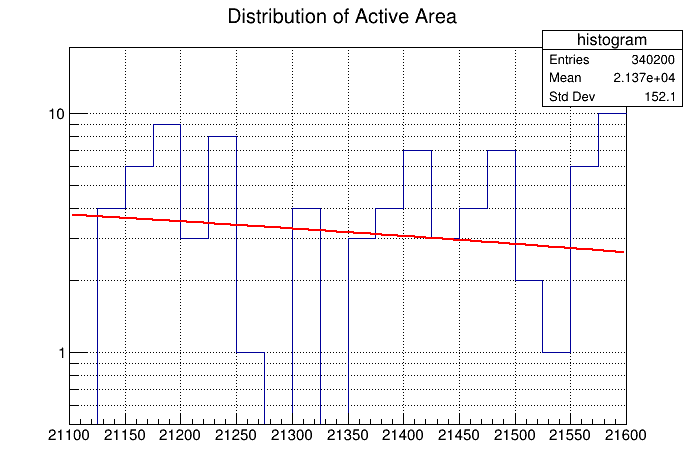

In [46]:
c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# c1.SetLogx()
# Range = [84350, 84550]
# Range = [-120, 120]
Range = [21100, 21600]
# Range = [30, 40]
# Range = [40, 50]
# Range = [10000, 11000] # ~ 250 bins
# Bins_fit = 100
Bins_fit = 20

histAA=TH1F("histogram", "Distribution of Active Area",Bins_fit, Range[0], Range[1])
histAA.AddDirectory(False)
for pixel_value in list_data_image:
    # if not np.ma.is_masked(pixel_value):
    histAA.Fill(pixel_value)
    #print(pixel_value)

fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2.SetParameters(4.8,10, 1, 400, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histAA.Fit("gaus")


# print('Parameters of the Doble-Gaussian Fit')
# print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
# print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
# # print('First Peak: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# # print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
# print("chiSquare: " + str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
# print("Prob:", fgaus2.GetProb(), '\n')

histAA.Draw()
c1.Draw()

Parameters of the Fit
Origen:  0.02541374881729054  +-  0.0002509359977545775
Pend:  0.004726508096570682  +-  1.4307406846956403e-07
chiSquare: 4404.212109797156
NDegrees of Freedom: 14
chiSquare / NDF : 314.5865792712254
Prob: 0.0 

 FCN=4404.21 FROM MIGRAD    STATUS=CONVERGED     159 CALLS         160 TOTAL
                     EDM=4.28554e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.54137e-02   2.50936e-04   2.84095e-07   2.53140e+00
   2  p1           4.72651e-03   1.43074e-07  -2.00925e-10  -6.41745e+03


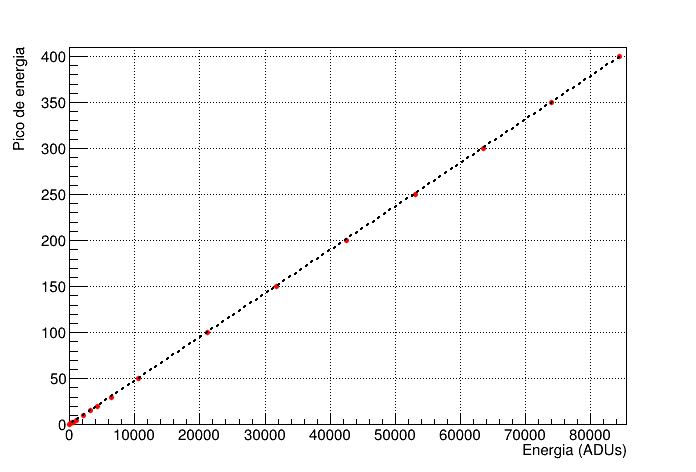

In [3]:
list_means = [0, 2.06375e+02, 4.16477e+02, 6.29785e+02, 1.05205e+03, 2.11725e+03, 3.17997e+03, 4.23982e+03, 6.36622e+03, 1.06014e+04, 2.11746e+04, 3.17445e+04, 4.24990e+04,
              5.30181e+04, 6.35051e+04, 74000, 8.44464e+04]
list_picos = [0, 1, 2, 3, 5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400]

list_err_means = [0, 6.71113e-02, 1.05089e-01, 1.50618e-01, 2.53065e-01, 6.18362e-01, 9.57621e-01,9.31032e-01, 1.91753e+00, 2.08932e+00, 2.92585e+00, 4.14678e+00, 5.20159e+00,
                  6.89924e+00, 4.62075e+00, 4.62075e+00, 4.62075e+00, 6.66879e+00]
list_err_picos = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


GRprofXY = TGraphErrors()



for index in np.arange(0, len(list_means)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])

# for index in np.arange(0, len(list_means)):
#     GRprofXY.SetPoint(int(index), list_picos[index], list_means[index])
#     GRprofXY.SetPointError(int(index), list_err_picos[index], list_err_means[index])

lox = 0
hix = list_means[-1]
fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(1, 0.0001)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit(fitline)  


# xlow = 200
# xhi = list_means[-1]
# fitnonline = TF1("fitnonline", "[0]+[1]*x", xlow, xhi) 
# fitnonline.SetParameters(1.0, 10.,)
# fitnonline.SetLineStyle(4)
# fitnonline.SetLineColor(3)
# GRprofXY.Fit(fitnonline) 


NBX= int(list_means[-1]) + 1000
NBY= list_picos[-1] + 10
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (ADUs)")
frame.GetYaxis().SetTitle("Pico de energia")

# frame.GetYaxis().SetTitle("Energia (e-)")
# frame.GetXaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.5)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
# fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


# print('Parameters of the Non-linear Fit')
# print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
# print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
# print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

# print("chiSquare: " + str(fitnonline.GetChisquare()))
# print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
# print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
# print("Prob:", fitnonline.GetProb(), '\n')


 FCN=0.00610315 FROM MIGRAD    STATUS=CONVERGED      26 CALLS          27 TOTAL
                     EDM=2.12792e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -5.78269e+00   1.89857e+01   5.35600e-03   1.09137e-05
   2  p1           2.11738e+02   9.09709e+00   2.56640e-03  -5.18824e-05


Warning in <TROOT::Append>: Replacing existing TH1: frame (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


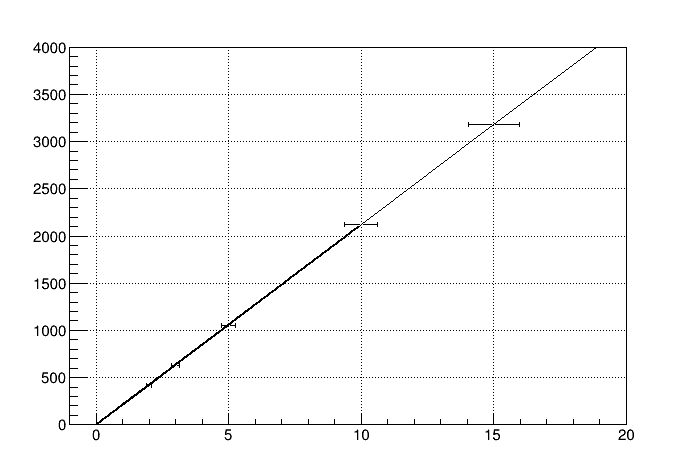

In [4]:
list_means = [0, 2.06375e+02, 4.16477e+02, 6.29785e+02, 1.05205e+03, 2.11725e+03, 3.17997e+03, 4.23982e+03, 6.36622e+03, 1.06014e+04, 2.11946e+04, 3.17845e+04, 4.24e+04,
              5.30181e+04, 6.36251e+04, 7.42263e+04, 8.48364e+04]
list_picos = [0, 1, 2, 3, 5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400]

list_err_means = [0, 6.71113e-02, 1.05089e-01, 1.50618e-01, 2.53065e-01, 6.18362e-01, 9.57621e-01,9.31032e-01, 1.91753e+00, 2.08932e+00, 2.92585e+00, 4.14678e+00, 5.20159e+00,
                  6.89924e+00, 4.62075e+00, 4.62075e+00, 4.62075e+00, 6.66879e+00]
list_err_picos = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for index in range(0, len(list_means)):
    GRprofXY.SetPoint(int(index),list_picos[index], list_means[index])
    # GRprofXY.SetPointError(int(index), list_err_picos[index], list_err_means[index])

NBX= int(list_picos[-1]) + 1000
NBY= list_means[-1]
frame = TH2F("frame", "", 20,-1, 20,4*10**3,0, 4*10**3)
frame.SetStats(0)

GRprofXY.GetYaxis().SetTitle("Energia (ADUs)")
GRprofXY.GetXaxis().SetTitle("Electrons")

lox = 0
hix = 10
fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(-5.78, 211.739)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit(fitline, "R") 


canv = TCanvas("c2")
canv.SetGrid()

frame.Draw()
GRprofXY.Draw('same')
fitline.Draw('same')
canv.Draw()


(-0.004, 0.004)

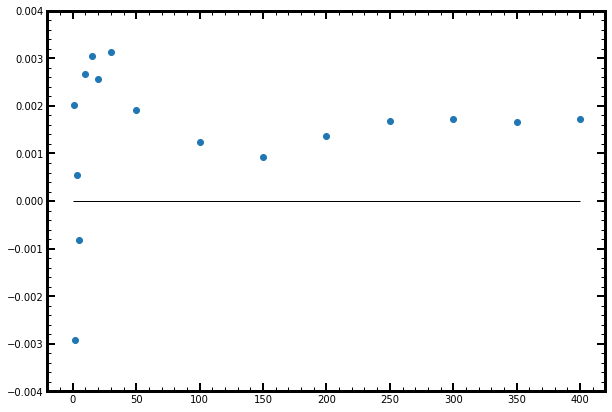

In [16]:
def line(x, m, a):
    return a + m*x

list_diffs = []
for index in range(0, len(list_picos)):
    val_fit = line(list_picos[index], 211.739, -5.78)
    diff = (list_means[index] - val_fit)
    # diff = ( val_fit - list_means[index])
    list_diffs.append(diff/val_fit)

fig, axs = plt.subplots(figsize = [10,7])
axs.scatter(list_picos[1:], list_diffs[1:])
axs.hlines(y=0, xmax=400, xmin=0, colors='k')
axs.set_ylim(-0.004, 0.004)


Prob: 3.5044749488117994e-33
Prob: 0.11753939290883833
Prob: 0.9920401693137341
Prob: 0.8954197130698817
Prob: 0.9983275249774123
Ajuste del fit in range ( 0 ,  1000 ):  0.004732683904660717  ADUs/e- or  211.2965962115506  e-/ADUs
Ajuste del fit in range ( 1000 ,  3200 ):  0.004697564640679895  ADUs/e- or  212.87626174214103  e-/ADUs
Ajuste del fit in range ( 3150 ,  10100 ):  0.004708711876806807  ADUs/e- or  212.3723060919467  e-/ADUs
Ajuste del fit in range ( 10000 ,  43000 ):  0.004705237789476528  ADUs/e- or  212.52911005614726  e-/ADUs
Ajuste del fit in range ( 42000 ,  85000 ):  0.004767496533148035  ADUs/e- or  209.75369212060824  e-/ADUs


 FCN=144.027 FROM MIGRAD    STATUS=CONVERGED      96 CALLS          97 TOTAL
                     EDM=8.99676e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.42500e-02   5.80940e-

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


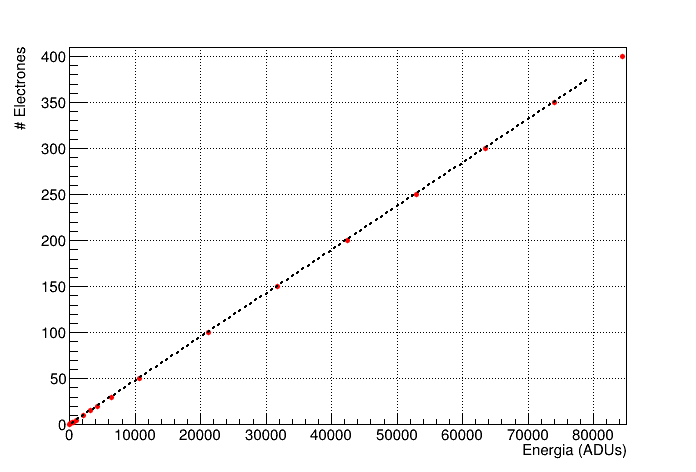

In [178]:
# list_means = [0, 2.06375e+02, 4.16477e+02, 6.29785e+02, 1.05205e+03, 2.11725e+03, 3.17997e+03, 4.23982e+03, 6.36622e+03, 1.06014e+04, 2.11746e+04, 3.17445e+04, 4.24990e+04,
#               5.30181e+04, 6.35051e+04, 74000, 8.44464e+04]
# list_picos = [0, 1, 2, 3, 5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400]

list_pend = []

list_lim_inf = [0, 1000, 3150, 10000, 42000,]
list_lim_sup = [1000, 3200, 10100, 43000, 85000]

NBX= int(list_lim_sup[-1])
NBY= 410

# NBX= 5000
# NBY= 25


canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (ADUs)")
frame.GetYaxis().SetTitle("# Electrones")
frame.SetStats(0)
frame.Draw()
GRprofXY.Draw("P same")


xlow = list_lim_inf[0]
xhi = list_lim_sup[0]
fitline_1 = TF1("fitline_1", "[0]+[1]*x", xlow, xhi) 
fitline_1.SetParameters(0, 0.001)
fitline_1.SetLineStyle(4)
fitline_1.SetLineColor(1)
GRprofXY.Fit("fitline_1", "0R")

fitline_1.SetRange(0, 80000)
fitline_1.Draw("L same")

list_pend.append(fitline_1.GetParameters()[1])
# print('Parameters of the linear Fit in range (' + str(xlow) + ', ' + str(xhi) + ')')
# print('Origen: ', fitline_1.GetParameters()[0],  ' +- ', fitline_1.GetParError(0))
# print('Pend: ', fitline_1.GetParameters()[1],  ' +- ', fitline_1.GetParError(1))
# print('Non-linear term: ', fitline_1.GetParameters()[2],  ' +- ', fitline_1.GetParError(2))

# print("chiSquare: " + str(fitline_1.GetChisquare()))
# print("NDegrees of Freedom: " + str(fitline_1.GetNDF()))
# print("chiSquare / NDF :", fitline_1.GetChisquare() / fitline_1.GetNDF())
print("Prob:", fitline_1.GetProb())

xlow = list_lim_inf[1]
xhi = list_lim_sup[1]
fitline_2 = TF1("fitline_2", "[0]+[1]*x", xlow, xhi) 
fitline_2.SetParameters(0, 0.001)
fitline_2.SetLineStyle(4)
fitline_2.SetLineColor(4)
GRprofXY.Fit("fitline_2", "0R")
# fitline_2.Draw("L same")
list_pend.append(fitline_2.GetParameters()[1])

# print('Parameters of the linear Fit in range (' + str(xlow) + ', ' + str(xhi) + ')')
# print('Origen: ', fitline_2.GetParameters()[0],  ' +- ', fitline_2.GetParError(0))
# print('Pend: ', fitline_2.GetParameters()[1],  ' +- ', fitline_2.GetParError(1))
# print('Non-linear term: ', fitline_2.GetParameters()[2],  ' +- ', fitline_2.GetParError(2))

# print("chiSquare: " + str(fitline_2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fitline_2.GetNDF()))
# print("chiSquare / NDF :", fitline_2.GetChisquare() / fitline_2.GetNDF())
print("Prob:", fitline_2.GetProb())

xlow = list_lim_inf[2]
xhi = list_lim_sup[2]
fitline_3 = TF1("fitline_2", "[0]+[1]*x", xlow, xhi) 
fitline_3.SetParameters(0, 0.001)
fitline_3.SetLineStyle(4)
fitline_3.SetLineColor(5)
GRprofXY.Fit("fitline_2", "0R")
# fitline_3.Draw("L same")
list_pend.append(fitline_3.GetParameters()[1])
print("Prob:", fitline_3.GetProb())

xlow = list_lim_inf[3]
xhi = list_lim_sup[3]
fitline_4 = TF1("fitline_2", "[0]+[1]*x", xlow, xhi) 
fitline_4.SetParameters(0, 0.001)
fitline_4.SetLineStyle(4)
fitline_4.SetLineColor(6)
GRprofXY.Fit("fitline_2", "0R")
# fitline_4.Draw("L same")
list_pend.append(fitline_4.GetParameters()[1])
print("Prob:", fitline_4.GetProb())

xlow = list_lim_inf[4]
xhi = list_lim_sup[4]
fitline_5 = TF1("fitline_2", "[0]+[1]*x", xlow, xhi) 
fitline_5.SetParameters(0, 0.001)
fitline_5.SetLineStyle(4)
fitline_5.SetLineColor(7)
GRprofXY.Fit("fitline_2", "0R")
# fitline_5.Draw("L same")
list_pend.append(fitline_5.GetParameters()[1])
print("Prob:", fitline_5.GetProb())

canv.Draw()
# print( len(list_pend))

# list_lim_inf = [0,    1000, 3150,  10000, 42000,]
# list_lim_sup = [1000, 3200, 10100, 43000, 85000]
for index in np.arange(0, len(list_pend)):
    # print(index)
    print('Ajuste del fit in range (', list_lim_inf[index], ', ', list_lim_sup[index], '): ', list_pend[index], ' ADUs/e- or ', 1/list_pend[index], ' e-/ADUs')
print('\n')

## Multiples imágenes (electrones)

Offset Value:  14910.0  ADUs
213.37272818066896
Offset Value:  14920.0  ADUs
213.36905363114542
Offset Value:  14916.667  ADUs
212.98389051195545
Offset Value:  14936.667  ADUs
213.71370014412574
Offset Value:  14950.0  ADUs
211.75901948980717
Offset Value:  14920.0  ADUs
214.02376241563678
Offset Value:  14923.333  ADUs
213.92345935635055
Offset Value:  14923.333  ADUs
212.9227245177964
Offset Value:  14940.0  ADUs
211.71460430569616


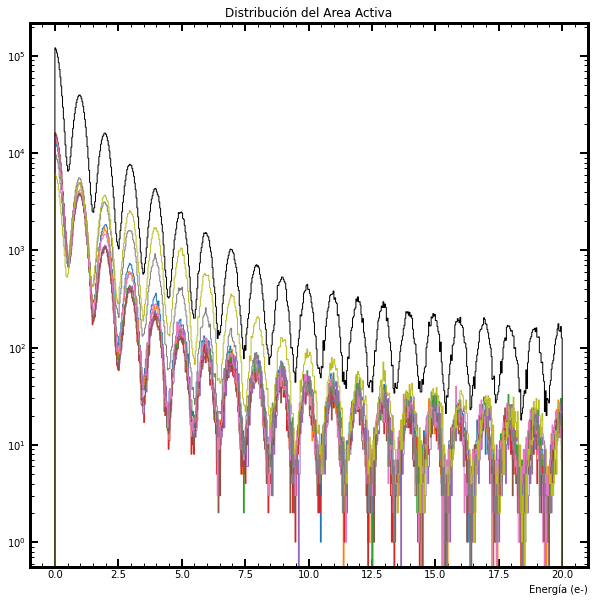

 FCN=620.333 FROM MIGRAD    STATUS=CONVERGED     396 CALLS         397 TOTAL
                     EDM=3.59162e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.23587e+00   3.79769e-01   3.29453e-04  -6.09626e-05
   2  p1           4.55625e+01   2.29284e-01  -7.64770e-05   3.64939e-04
   3  p2           2.13373e+02   7.67832e-01  -3.63265e-04  -8.35920e-05
   4  p3           4.77515e+02   2.14454e+00   3.76578e-04   3.43279e-06
   5  p4           3.15066e+01   4.68585e-01   8.63756e-05   1.91540e-04
 FCN=624.591 FROM MIGRAD    STATUS=CONVERGED     359 CALLS         360 TOTAL
                     EDM=6.70392e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p

In [189]:
extension = 1
Bins = 600
Bins_fit = 600
Range_fit = [-30, 350]

list_path = ['../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_103.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_105.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_106.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_107.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_108.fits',]
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_109.fits']
list_data_image = []
Gain_ref = 213.37272818066896

c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)

fig, axs = plt.subplots(figsize = [10,10])

for index in np.arange(0, len(list_path)):
    hdu_list = fits.open(list_path[index])
    # hdu_list = fits.open(path)
    active_area = hdu_list[extension-1].data[:, :550]
    Overscan = hdu_list[extension - 1].data[:, 550:]

    # print('Dimensiones Oscan: ', Overscan.shape)
    oscan_x = Overscan.shape[1]
    oscan_y = Overscan.shape[0]


    ### Dimensiones de Active Area
    # print('Dimensiones ActA: ', active_area.shape)
    acta_x = active_area.shape[1]
    acta_y = active_area.shape[0]

    ### Se sustrae la mediana de cada renglón y se crea un arreglo
    mean_rows_value = []

    for element in np.arange(0, oscan_y):
        row = Overscan[element: element +1, 0: oscan_x]
        num_row = element + 1
        # plt.imshow(row, origin='lower')
        # plt.show()
        # print(row.shape)
        # print(type(row))
        # print(row.sum()/row.shape[1])
        mean_value = np.median(row)
        mean_rows_value.append([mean_value])
        # print((num_row, mean_value))

    ### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
    true_active_area = active_area - mean_rows_value
    # true_active_area = active_area

        
    hist , bins_edges = np.histogram(Overscan.flatten(), bins = Bins,  range=(14000, 16000))
    offset = bins_edges[np.argmax(hist)]
    print('Offset Value: ', offset, ' ADUs')
    # Active_area_plane = true_active_area - offset 
    Overscan_plane = Overscan - offset 
    

    h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    h3.AddDirectory(False)

    for pixel_value in Overscan_plane.flatten():
        # if not np.ma.is_masked(pixel_value):
        h3.Fill(pixel_value)
        #print(pixel_value)

    fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    h3.Fit(fgaus2)
    Gain_i = fgaus2.GetParameters()[2]
    sig_ADUs = fgaus2.GetParameters()[1]
    print(Gain_i)

    ## SEcalibran los datos en electrones ##
    dataCal, _ = data_calibrated_NSAMP(active_area = true_active_area, extension = extension, offset = offset, gain = Gain_i, ratio_keV = 0.00036, unidades = 1, sigma_ADUs = sig_ADUs)

    hAcA=TH1F("histogram", "Distribution of Active Area",Bins_fit, 0, 20)
    hAcA.AddDirectory(False)
    for pixel_value in dataCal.flatten():
        # if not np.ma.is_masked(pixel_value):
        hAcA.Fill(pixel_value)
        #print(pixel_value)

    # axs.hist(dataCal.flatten(), bins = Bins, range = [0, 10],  histtype = 'step')
    # plt.yscale('log')
    # hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
    # offset = bins_edges[np.argmax(hist)]
    # print('Offset Value: ', offset, ' ADUs')
    # Active_area = data - offset 
    
    # # plt.hist(Active_area.flatten(), 100, -100, 600)
    # h3 = 0
    # h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    # h3.AddDirectory(False)

    # for pixel_value in Active_area.flatten():
    #     # if not np.ma.is_masked(pixel_value):
    #     h3.Fill(pixel_value)
    #     #print(pixel_value)
    
    # fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    # fgaus2.SetParameters(0,50,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    # h3.Fit(fgaus2)

    # Gain_i = fgaus2.GetParameters()[2]

    # true_data = dataCal * (Gain_i / Gain_ref)
    # hAcA.Draw()
    true_data = dataCal.flatten()

    axs.hist(true_data, bins = Bins, range = [0, 20],  histtype = 'step')

    # print(true_data)
    
    for element in true_data:
        list_data_image.append(element)
    # print(dataCal)

    # c1.Draw()

# fgaus2.Draw("same")

axs.hist(list_data_image, bins = Bins, range = [0, 20],  histtype = 'step', color = 'k')
plt.xlabel('Energía (e-)')
plt.title('Distribución del Area Activa')
plt.yscale('log')
plt.show()

 FCN=1056.5 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=6.12806e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.57199e+03   4.18115e+00   5.06556e-02   3.12011e-05
   2  Mean         1.96069e+00   4.56266e-04   7.18109e-06   1.32816e+00
   3  Sigma        2.09354e-01   4.09088e-04   8.09282e-06  -1.13439e+00


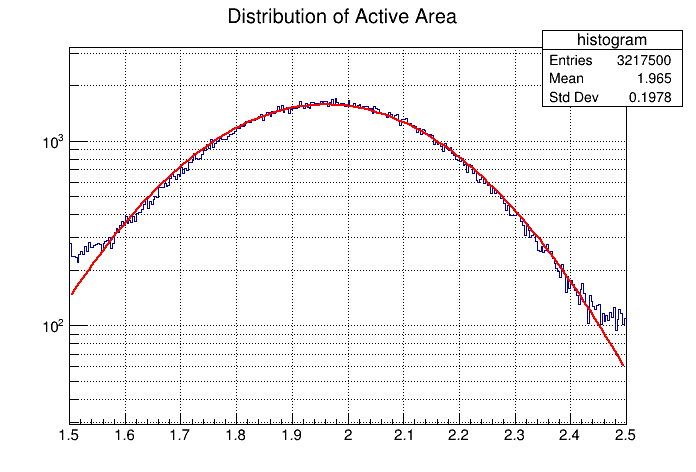

In [182]:
c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# c1.SetLogx()
Range = [1.5, 2.5]
# Range = [10, 20]
# Range = [20, 30]
# Range = [30, 40]
# Range = [40, 50]
# Range = [294, 297] # ~ 250 bins
Bins_fit = 300

histAA=TH1F("histogram", "Distribution of Active Area",Bins_fit, Range[0], Range[1])
histAA.AddDirectory(False)
for pixel_value in list_data_image:
    # if not np.ma.is_masked(pixel_value):
    histAA.Fill(pixel_value)
    #print(pixel_value)

fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2.SetParameters(4.8,10, 1, 400, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histAA.Fit("gaus")


# print('Parameters of the Doble-Gaussian Fit')
# print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
# print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
# # print('First Peak: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# # print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
# print("chiSquare: " + str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
# print("Prob:", fgaus2.GetProb(), '\n')

histAA.Draw()
c1.Draw()

Parameters of the Fit
Origen:  0.026475422893125957  +-  0.00028493958155433063
Pend:  1.001494840812698  +-  9.869614323660295e-05
chiSquare: 6455.012977407059
NDegrees of Freedom: 21
chiSquare / NDF : 307.3815703527171
Prob: 0.0 

Parameters of the Non-linear Fit
Origen:  0.026475339528417914  +-  0.0002849704948002273
Pend:  1.0014948782632809  +-  9.872003573197893e-05
Non-linear term:  1.6e-322  +-  0.0
chiSquare: 6455.012977571968
NDegrees of Freedom: 21
chiSquare / NDF : 307.3815703605699
Prob: 0.0 

 FCN=6455.01 FROM MIGRAD    STATUS=CONVERGED      48 CALLS          49 TOTAL
                     EDM=1.5392e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.64754e-02   2.84940e-04   8.30326e-06   5.77373e-02
   2  p1           1.00149e+00   9.86961e-05   2.87623e-06  -1.66179e+00
 FCN=6455.01 FROM MIGRAD    STATUS=CONVER

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


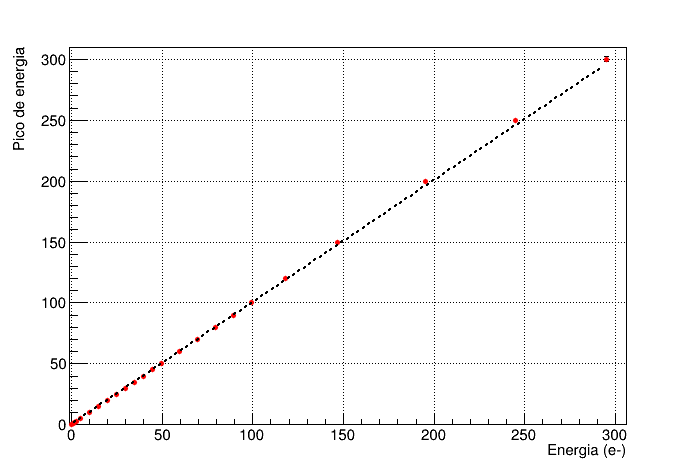

In [187]:
list_means = [-0.0222, 9.65085e-01, 1.96069e+00, 3, 4.951, 9.9491, 14.935, 19.896, 2.48970e+01, 2.98767e+01, 3.48370e+01, 3.98027e+01, 4.48113e+01, 
              4.97893e+01, 5.96377e+01, 6.95188e+01, 7.92982e+01, 8.91824e+01, 99.150, 118.1, 146.9, 195.5, 244.9, 295.1]
list_picos = [0, 1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300]

list_err_means = [0.00015, 2.91514e-04, 4.56266e-04, 4.56266e-04, 1.15417e-03, 2.84331e-03, 4.09970e-03, 5.14658e-03, 7.56068e-03, 1.01108e-02, 1.20870e-02, 1.44099e-02, 1.69816e-02,
                  2.60153e-02, 5.46762e-02, 3.35834e-02,  4.30418e-02,1,1,1,1,1, 1, 1]
list_err_picos = [0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]


GRprofXY = TGraphErrors()

lox = 0
hix = list_means[-1]

for index in np.arange(0, len(list_means)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])

# for index in np.arange(0, len(list_means)):
#     GRprofXY.SetPoint(int(index), list_picos[index], list_means[index])
#     GRprofXY.SetPointError(int(index), list_err_picos[index], list_err_means[index])


fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(0, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit("fitline", "0R")  


xlow = 0
xhi = list_means[-1]
fitnonline = TF1("fitnonline", "[0]+[1]*x", xlow, xhi) 
fitnonline.SetParameters(1.0, 10.,)
fitnonline.SetLineStyle(4)
fitnonline.SetLineColor(3)
GRprofXY.Fit("fitnonline", "0R") 


NBX= int(list_means[-1]) + 10
NBY= list_picos[-1] + 10
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (e-)")
frame.GetYaxis().SetTitle("Pico de energia")

# frame.GetYaxis().SetTitle("Energia (e-)")
# frame.GetXaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.5)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


print('Parameters of the Non-linear Fit')
print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

print("chiSquare: " + str(fitnonline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
print("Prob:", fitnonline.GetProb(), '\n')


Parameters of the linear Fit in range (-0.5, 2)
Origen:  0.02275357789162198  +-  0.0001461861727849805
Pend:  1.0100077608371305  +-  0.00021046098739689806
Non-linear term:  3.3e-322  +-  0.0
chiSquare: 121.3150409288145
NDegrees of Freedom: 1
chiSquare / NDF : 121.3150409288145
Prob: 3.2602234034257885e-28 

Parameters of the linear Fit in range (-0.5, 5)
Origen:  0.024313861542096644  +-  0.00014032850218995913
Pend:  1.0001205665497797  +-  0.00011994075364480205
Non-linear term:  1.6e-322  +-  0.0
chiSquare: 5897.157582922988
NDegrees of Freedom: 3
chiSquare / NDF : 1965.7191943076625
Prob: 0.0 

 FCN=121.315 FROM MIGRAD    STATUS=CONVERGED      48 CALLS          49 TOTAL
                     EDM=5.27038e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.27536e-02   1.46186e-04   6.98185e-07   1.15740e+00
   2  p1        

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


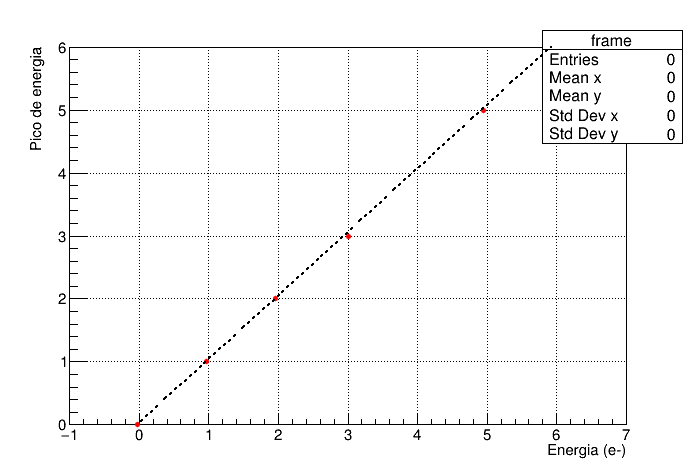

In [184]:
# list_means = [-0.0222, 9.65085e-01, 1.96069e+00, 3, 4.951, 9.9491, 14.935, 19.896, 2.48970e+01, 2.98767e+01, 3.48370e+01, 3.98027e+01, 4.48113e+01, 
#               4.97893e+01, 5.96377e+01, 6.95188e+01, 7.92982e+01, 8.91824e+01, 99.150, 118.1, 146.9, 195.5, 244.9, 295.1]
# list_picos = [0, 1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300]

list_lim_inf = [-0.5, -0.5, -0.5, 5, 10, 10, 20, 50, 50]
list_lim_sup = [2, 5, 10, 20, 30, 50, 100, 200, 300]
NBX= 6
NBY= 6
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (e-)")
frame.GetYaxis().SetTitle("Pico de energia")
frame.Draw()
GRprofXY.Draw("P same")


xlow = list_lim_inf[0]
xhi = list_lim_sup[0]
fitline_1 = TF1("fitline_1", "[0]+[1]*x", xlow, xhi) 
fitline_1.SetParameters(0, 1.)
fitline_1.SetLineStyle(4)
fitline_1.SetLineColor(1)
GRprofXY.Fit("fitline_1", "0R")
fitline_1.SetRange(0, 300)
fitline_1.Draw("L same")

print('Parameters of the linear Fit in range (' + str(xlow) + ', ' + str(xhi) + ')')
print('Origen: ', fitline_1.GetParameters()[0],  ' +- ', fitline_1.GetParError(0))
print('Pend: ', fitline_1.GetParameters()[1],  ' +- ', fitline_1.GetParError(1))
print('Non-linear term: ', fitline_1.GetParameters()[2],  ' +- ', fitline_1.GetParError(2))

print("chiSquare: " + str(fitline_1.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline_1.GetNDF()))
print("chiSquare / NDF :", fitline_1.GetChisquare() / fitline_1.GetNDF())
print("Prob:", fitline_1.GetProb(), '\n')

xlow = list_lim_inf[1]
xhi = list_lim_sup[1]
fitline_2 = TF1("fitline_2", "[0]+[1]*x", xlow, xhi) 
fitline_2.SetParameters(0, 1.)
fitline_2.SetLineStyle(4)
fitline_2.SetLineColor(4)
GRprofXY.Fit("fitline_2", "0R")
# fitline_2.Draw("L same")

print('Parameters of the linear Fit in range (' + str(xlow) + ', ' + str(xhi) + ')')
print('Origen: ', fitline_2.GetParameters()[0],  ' +- ', fitline_2.GetParError(0))
print('Pend: ', fitline_2.GetParameters()[1],  ' +- ', fitline_2.GetParError(1))
print('Non-linear term: ', fitline_2.GetParameters()[2],  ' +- ', fitline_2.GetParError(2))

print("chiSquare: " + str(fitline_2.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline_2.GetNDF()))
print("chiSquare / NDF :", fitline_2.GetChisquare() / fitline_2.GetNDF())
print("Prob:", fitline_2.GetProb(), '\n')
canv.Draw()
